In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
proj_dir = os.path.split(os.getcwd())[0]

%matplotlib inline

audit_df = pd.read_pickle(f'{proj_dir}/data/cleaned/audit.pkl')
auth_df = pd.read_pickle(f'{proj_dir}/data/cleaned/auth.pkl')
net_df = pd.read_pickle(f'{proj_dir}/data/cleaned/netflow.pkl')
win_df = pd.read_pickle(f'{proj_dir}/data/cleaned/win-security.pkl')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
# KNN
# RandomForest (ensemble)
# SVM
# SGDC
# Bagging



In [2]:
df = net_df

In [3]:
df.columns

Index(['flow_start', 'flow_end', 'expiration_id', 'src_ip', 'src_mac',
       'src_port', 'dst_ip', 'dst_mac', 'dst_port', 'protocol',
       'bidirectional_first_seen_ms', 'bidirectional_last_seen_ms',
       'bidirectional_duration_ms', 'bidirectional_packets',
       'bidirectional_bytes', 'src2dst_first_seen_ms', 'src2dst_duration_ms',
       'src2dst_packets', 'src2dst_bytes', 'dst2src_first_seen_ms',
       'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
       'src2dst_min_ps', 'src2dst_mean_ps', 'src2dst_stddev_ps',
       'src2dst_max_ps', 'dst2src_min_ps', 'dst2src_mean_ps',
       'dst2src_stddev_ps', 'dst2src_max_ps', 'src2dst_min_piat_ms',
       'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms', 'src2dst_max_piat_ms',
       'dst2src_min_piat_ms', 'dst2src_mean_piat_ms', 'dst2src_stddev_piat_ms',
       'dst2src_max_piat_ms', 'src2dst_syn_packets', 'src2dst_cwr_packets',
       'src2dst_ece_packets', 'src2dst_urg_packets', 'src2dst_ack_packets',
       'src2dst_

In [ ]:
df['mean_bytes_per_packet'] = (df['bidirectional_bytes'] / df['bidirectional_packets']).apply(round).astype('uint16')

In [ ]:
exfil = net_df[net_df['Stage'] == "Data Exfiltration"]
exfil_bytes = exfil.bidirectional_bytes

# not quite the amount of data exfil'd, as there are control/header bytes included.
print(f"Total size of exfil traffic: {exfil_bytes.sum() / (1024 * 1024):.1f} MB", exfil_bytes.sum())  
print(exfil_bytes.sum() / len(exfil_bytes))
print(exfil_bytes.min(), exfil_bytes.max())

Total size of exfil traffic: 150.3 MB 157556891
20946.14344589205
54 68279520


In [43]:
exfil[exfil_bytes == exfil_bytes.max()]

,flow_start,flow_end,expiration_id,src_ip,src_mac,src_port,dst_ip,dst_mac,dst_port,protocol,...,dst2src_fin_packets,application_name,application_category_name,server_fingerprint,user_agent,Activity,Stage,DefenderResponse,Signature,mean_bytes_per_packet
4249502,2021-07-02 22:30:12.736,2021-07-02 22:34:34.880,0,10.1.3.17,fa:16:3e:c7:60:b5,53965,10.8.10.84,fa:16:3e:2b:10:fa,443,6,...,1,TLS,Web,f4febc55ea12b31ae17cfb7e614afda8,NaN,Unsecured Credentials,Data Exfiltration,Benign,APT,5371


In [51]:
exfil.src_ip.value_counts().head(2)

src_ip
10.1.3.17    7076
10.1.3.8      446
Name: count, dtype: int64

In [39]:
net_df.iloc[4249502].values

array([Timestamp('2021-07-02 22:30:12.736000'),
       Timestamp('2021-07-02 22:34:34.880000'), np.uint16(0), '10.1.3.17',
       'fa:16:3e:c7:60:b5', np.uint16(53965), '10.8.10.84',
       'fa:16:3e:2b:10:fa', np.uint16(443), np.uint16(6), np.uint32(0),
       np.uint32(0), np.uint32(196053), np.uint32(12712),
       np.uint32(68279520), np.uint32(0), np.uint32(196052),
       np.uint32(1684), np.uint32(93804), np.uint32(0), np.uint32(196053),
       np.uint32(11028), np.uint32(68185720), np.uint16(54),
       np.uint16(55), np.uint16(21), np.uint16(398), np.uint16(54),
       np.uint16(6182), np.uint16(5339), np.uint16(12744), np.uint32(0),
       np.uint32(116), np.uint32(1238), np.uint32(15014), np.uint32(0),
       np.uint32(17), np.uint32(485), np.uint32(15015), np.uint16(1),
       np.uint16(0), np.uint16(0), np.uint16(0), np.uint32(1683),
       np.uint32(14), np.uint16(0), np.uint16(1), np.uint16(1),
       np.uint16(0), np.uint16(0), np.uint16(0), np.uint32(11025),
       np.

Malicious avg packet size: 146.75 bytes
Malicious median packet size: 134.00 bytes
Benign avg packet size: 326.58 bytes
Benign median packet size: 154.00 bytes

Difference in averages: 179.83 bytes
Difference in medians: 20.00 bytes

U-test statistic: 237,153,684,084
P-value: 0.0000e+00
Statistically significant?: True

Hypothesis: SUPPORTED


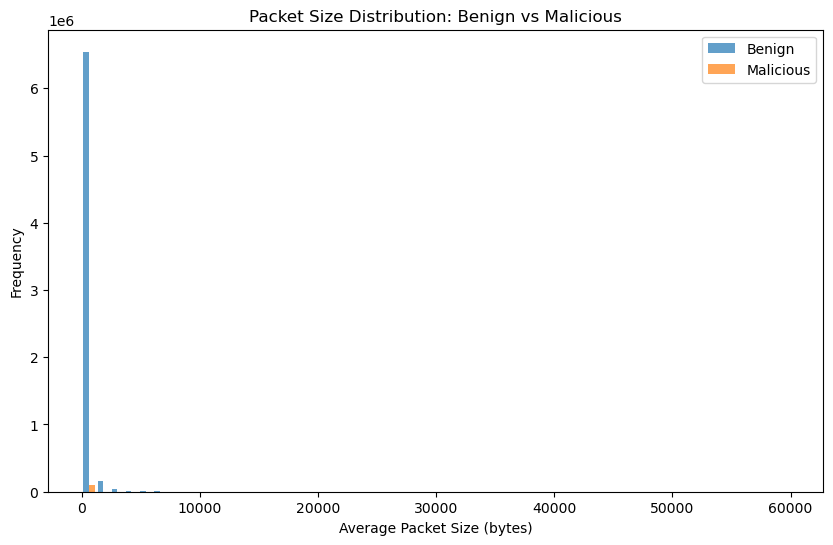

In [ ]:
# Hypothesis: Malicious network flows exhibit statistically different mean bytes per packet compared to benign flows, as measured by total bytes divided by total packets per flow session.
malicious_ps = df[df['Signature'] != 'Normal']['mean_bytes_per_packet']
normal_ps = df[df['Signature'] == 'Normal']['mean_bytes_per_packet']

print(f"Malicious avg packet size: {malicious_ps.mean():.2f} bytes")
print(f"Malicious median packet size: {malicious_ps.median():.2f} bytes")
print(f"Benign avg packet size: {normal_ps.mean():.2f} bytes")
print(f"Benign median packet size: {normal_ps.median():.2f} bytes")
print()
print(f"Difference in averages: {abs(malicious_ps.mean() - normal_ps.mean()):.2f} bytes")
print(f"Difference in medians: {abs(malicious_ps.median() - normal_ps.median()):.2f} bytes")

# Mann-Whitney U test - https://scienceinsights.org/what-is-the-mann-whitney-u-test-and-when-should-you-use-it/
# Using this as our data is not normally distributed, nor is it related - one network session does not directly cause another session.
'''
"A Mann-Whitney U test was selected because:
1. Network packet size data exhibits non-normal distribution with 
   right-skew and heavy tails (violates t-test normality assumption)
2. The two groups (benign vs. malicious) contain independent samples, 
   as network flows are not paired or causally related
3. Mann-Whitney U is a non-parametric test that compares distributions 
   without assuming normality, making it appropriate for this data"
'''
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(malicious_ps.dropna(), normal_ps.dropna())
print(f"\nU-test statistic: {stat:,.0f}")
print(f"P-value: {p_value:.4e}")
print(f"Statistically significant?: {p_value < 0.05}")
print(f"\nHypothesis: {'SUPPORTED' if p_value < 0.05 else 'NOT SUPPORTED'}")


# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist([normal_ps.dropna(), malicious_ps.dropna()], 
         label=['Benign', 'Malicious'], bins=50, alpha=0.7)
plt.xlabel('Average Packet Size (bytes)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Packet Size Distribution: Benign vs Malicious')
plt.show();
##plt.savefig('packet_size_comparison.png')

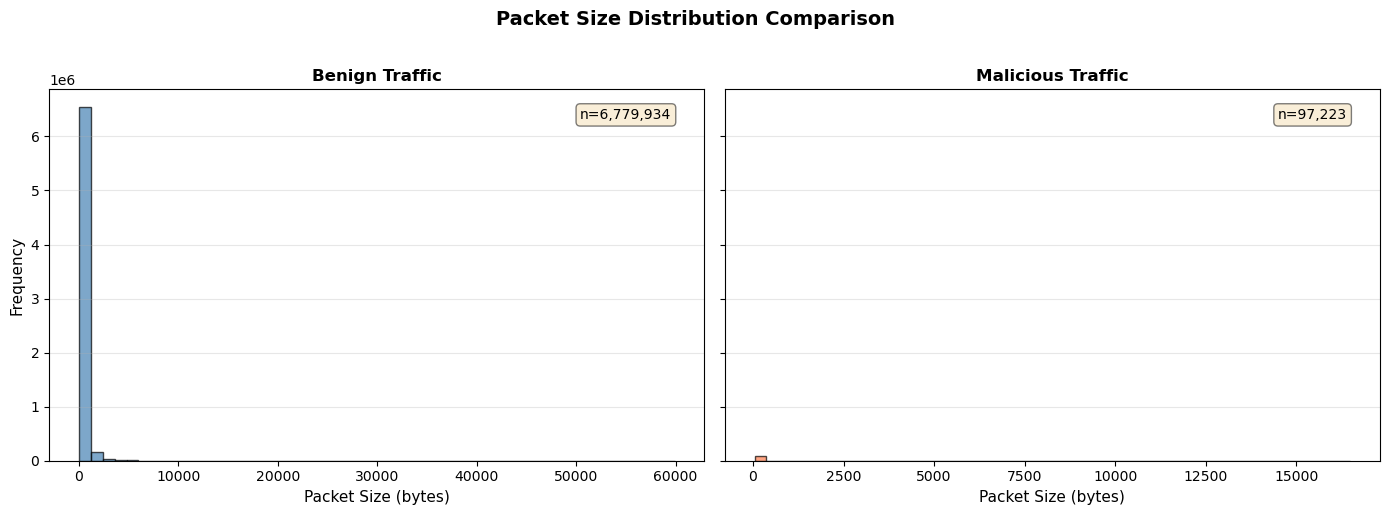

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Benign
axes[0].hist(normal_ps.dropna(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Packet Size (bytes)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Benign Traffic', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].text(0.95, 0.95, f'n={len(normal_ps):,}', transform=axes[0].transAxes,
             ha='right', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Malicious
axes[1].hist(malicious_ps.dropna(), bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Packet Size (bytes)', fontsize=11)
axes[1].set_title('Malicious Traffic', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].text(0.95, 0.95, f'n={len(malicious_ps):,}', transform=axes[1].transAxes,
             ha='right', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Packet Size Distribution Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
#plt.savefig('packet_size_sidebyside.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_20763/2919062234.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Benign', 'Malicious'],


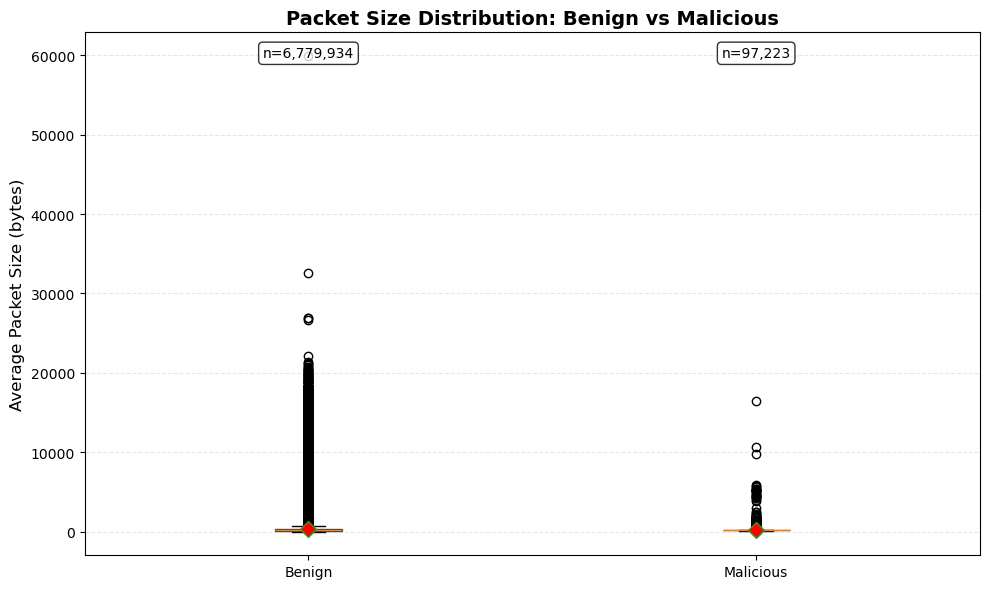

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

data_to_plot = [normal_ps.dropna(), malicious_ps.dropna()]
bp = ax.boxplot(data_to_plot, labels=['Benign', 'Malicious'], 
                patch_artist=True, showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

# Color the boxes
colors = ['steelblue', 'coral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Average Packet Size (bytes)', fontsize=12)
ax.set_title('Packet Size Distribution: Benign vs Malicious', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add sample sizes
for i, data in enumerate(data_to_plot):
    ax.text(i+1, ax.get_ylim()[1]*0.95, f'n={len(data):,}', 
            ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
#plt.savefig('packet_size_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

<Axes: >

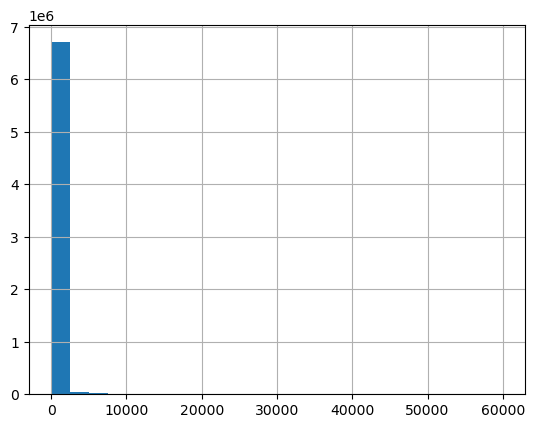

In [24]:
sturges_rule = round(1 + 3.322 * np.log10(len(normal_ps)))
normal_ps.hist(bins=sturges_rule)

<Axes: >

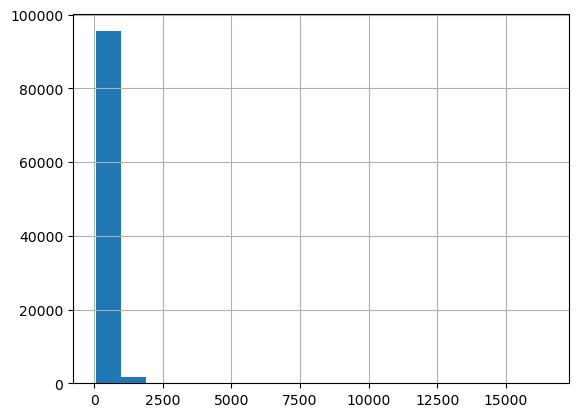

In [ ]:
sturges_rule = round(1 + 3.322 * np.log10(len(malicious_ps)))
malicious_ps.hist(bins=sturges_rule)